In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import h5py
import keras
from keras.models import load_model
from keras import backend as K
from keras import models

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_trainX, y_trainX), (x_testX, y_testX) = mnist.load_data()

Load mnist set,and get a subfilter of the dataset.

In [0]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [0]:
def filter_arr(arr,arr2,filter_vals):
  mask = np.isin(arr, filter_vals)
  indexes = np.where(mask)
  return arr[indexes],arr2[indexes]

In [0]:
y_train, x_train = filter_arr(y_trainX, x_trainX,[0,1])
y_test, x_test = filter_arr(y_testX, x_testX,[0,1])
x_validate = x_testX.copy()
y_validate = y_testX.copy()

Run a sample model and return history,score,trained model...


In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

def run_model(filter_digits):

  batch_size = 512
  num_classes = len(filter_digits)
  epochs = 50
  y_train, x_train = filter_arr(y_trainX, x_trainX,filter_digits )
  y_test, x_test = filter_arr(y_testX, x_testX,filter_digits )
  x_validate = x_test
  y_validate = y_test
  
  # input image dimensions
  img_rows, img_cols = 28, 28
  
  if K.image_data_format() == 'channels_first':
      x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
      x_validate = x_validate.reshape(x_validate.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)
  
  x_train = x_train.astype('float32')
  x_validate = x_validate.astype('float32')
  x_train /= 255
  x_validate /= 255
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(y_train.shape[0], 'train label samples')
  print(x_validate.shape[0], 'validation samples')
  print(y_validate.shape[0], 'validation label samples')
  
  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_validate = keras.utils.to_categorical(y_validate, num_classes)
  
 
  
  # Build the model
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (5, 5),
                   activation = 'relu',
                   input_shape = input_shape))
  model.add(Conv2D(32, kernel_size = (3, 3),
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes, activation = 'softmax'))
  
  model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, amsgrad=False),
                metrics = ['accuracy'])
  
  #
  esDelta = keras.callbacks.EarlyStopping(monitor='val_acc',mode='max', min_delta=1, patience=3 ,verbose=1)
  history = model.fit(x_train,y_train,
                      epochs = epochs,
                      batch_size = batch_size,
                      verbose = 0,
                      validation_data = (x_validate, y_validate),
                      callbacks=[esDelta]
                      )
  
  score = model.evaluate(x_validate, y_validate, verbose = 0)
  print('Validation loss:', score[0])
  print('Validation accuracy:', score[1])
  return [history, score,model,x_validate,y_validate]

In [21]:
history_0_1,score_0_1,current_model_0_1,x_validate_0_1,y_validate_0_1 = run_model([0,1])
print("score",score_0_1)

x_train shape: (12665, 28, 28, 1)
12665 train samples
12665 train label samples
2115 validation samples
2115 validation label samples
Epoch 00004: early stopping
Validation loss: 0.0035023614036781207
Validation accuracy: 0.9990543735224586
score [0.0035023614036781207, 0.9990543735224586]


Converted standart sample for visualizing laters into a class. Just give the trained model and test variables.

In [0]:
class model_vis:
  def __init__(self,trained_model,x_test_data,y_test_data):
    self.trained_model = trained_model
    self.x_test_data = x_test_data
    self.y_test_data = y_test_data

  def show_model_layers(self):
    uniques =  np.unique( self.y_test_data)
    for unique in uniques:
      label_index =  np.argwhere(self.y_test_data == unique)[0][0]        
      plt.figure(figsize = (3,3))
      plt.imshow(self.x_test_data[label_index,:], cmap = 'gray')
      plt.show()
      self.visualize_model(self.trained_model,self.x_test_data[label_index,:].reshape([1,28,28,1])) 

  def visualize_model(self,model,img):
    # Set the learning phase to false, the model is pre-trained.
    K.set_learning_phase(False)    
    layer_outputs = []
    layer_names = []
    flat_seen = False
    for layer in model.layers[:-1]:
      if layer.name.startswith('flat'):
        flat_seen = True
      if not flat_seen :
        layer_names.append(layer.name)
        layer_outputs.append(layer.output)
  
    activation_model = models.Model(input=model.input, output=layer_outputs)
    activations = activation_model.predict(img)
    
     
  
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        #change here if u want only specific layers to be visualized
        if 1 < 2 : #layer_name.startswith('conv') or  layer_name.startswith('dense'):
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))
            for col in range(n_cols):
                for row in range(images_per_row):                    
                    channel_image  = layer_activation[0,:, :, col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='gray')
    
     

Call the class with parameters, it will show activations for all unique items.

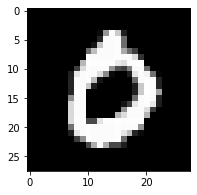

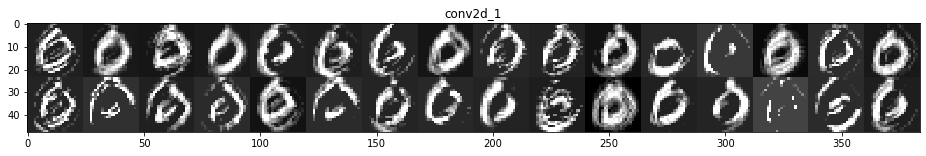

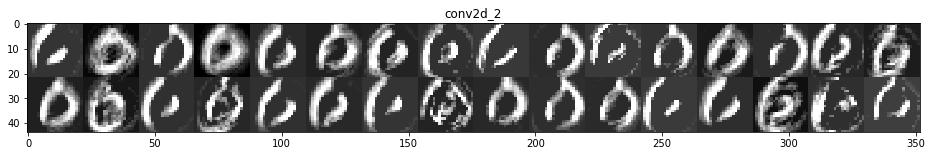

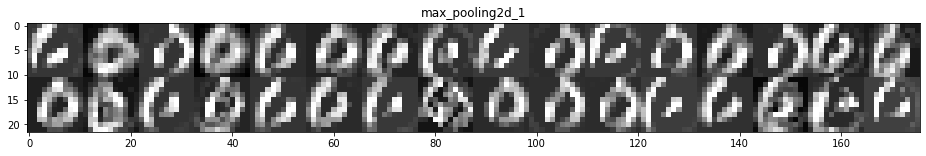

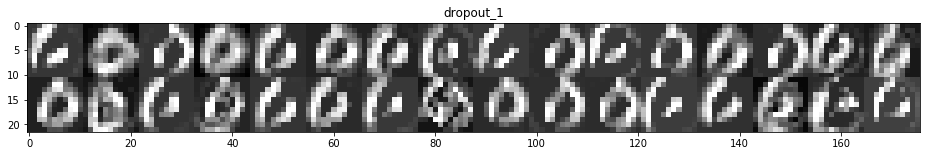

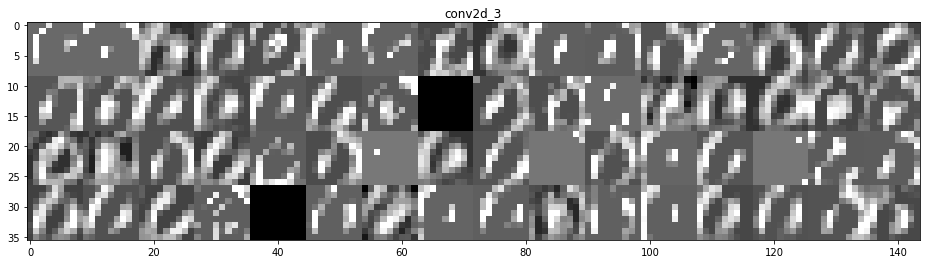

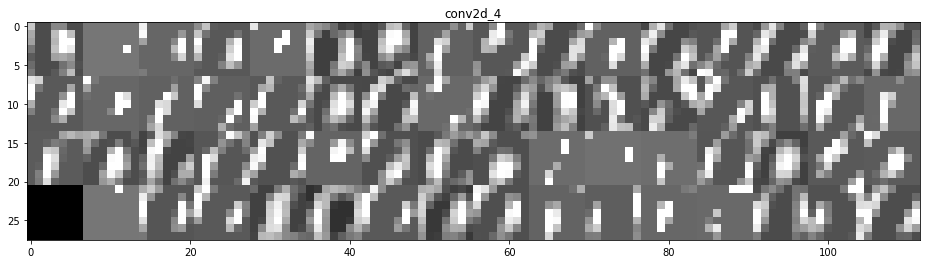

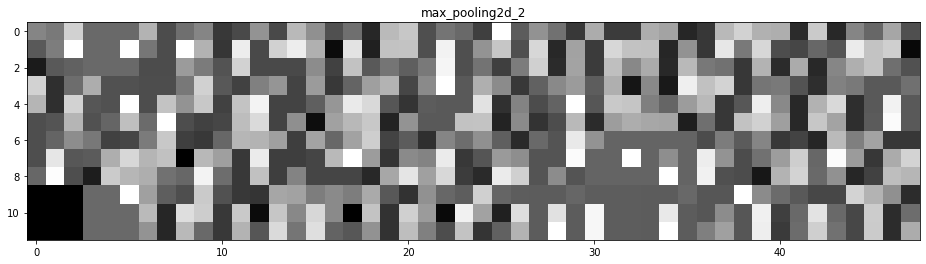

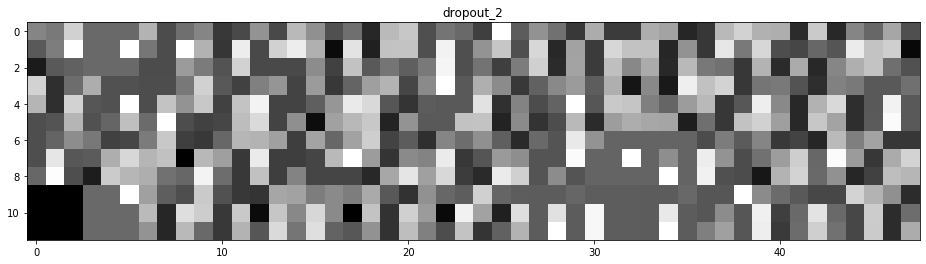

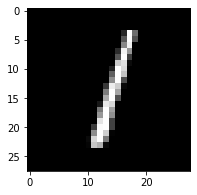

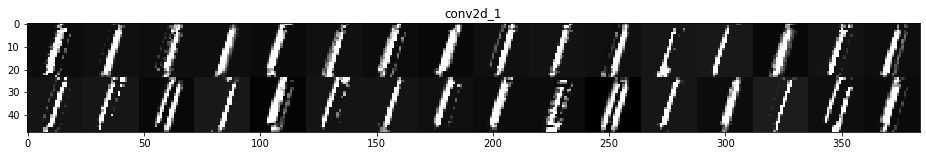

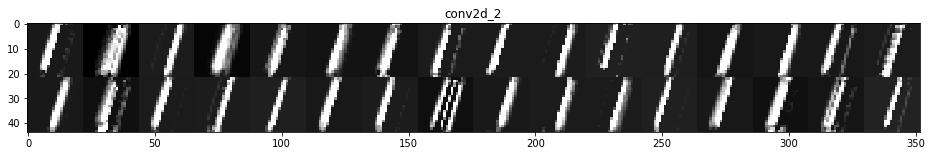

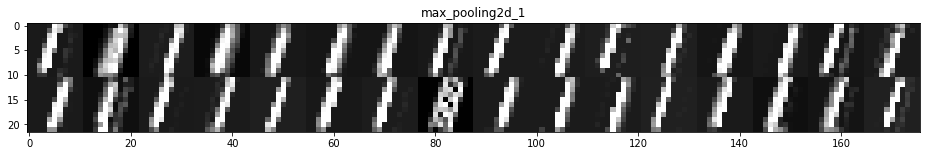

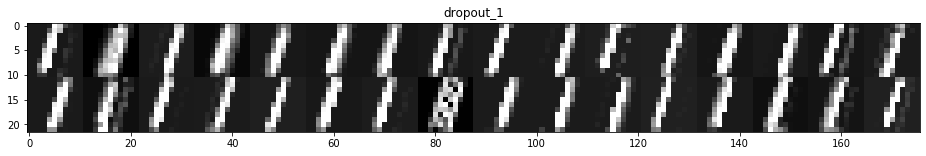

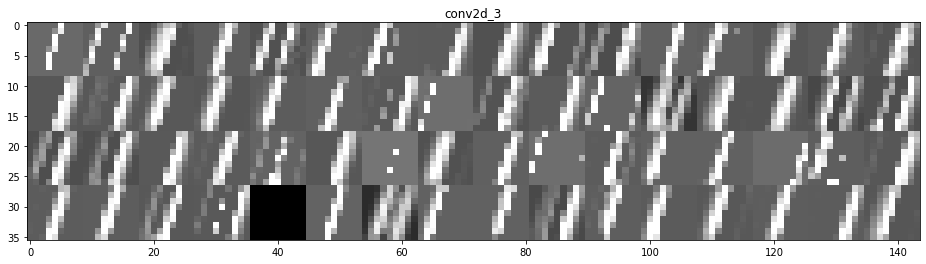

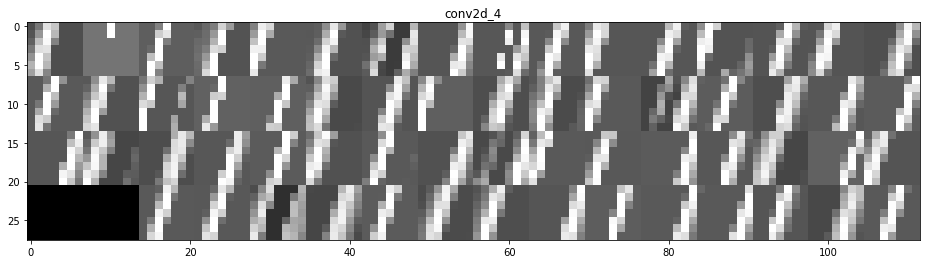

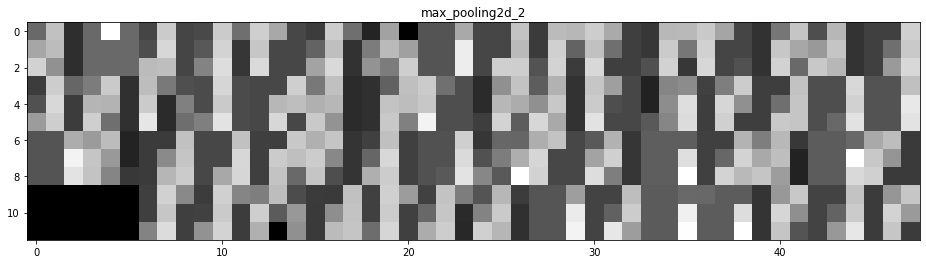

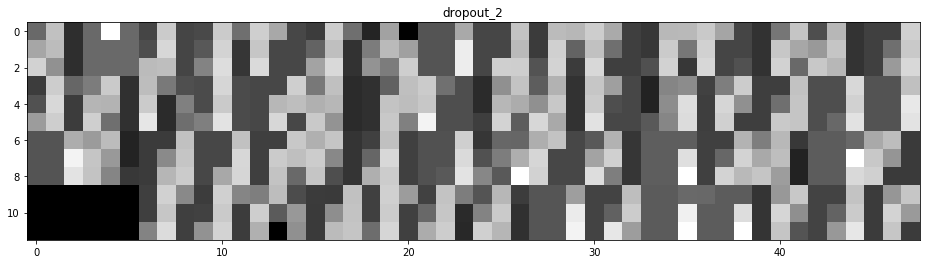

In [8]:
vis = model_vis(current_model,x_test,y_test)
vis.show_model_layers()